# Multicolinearity

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook we will check the impact of colinearity on the model coefficients.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

# the dataset for the demo
from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import f_regression, r_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns = ["Latitude", "Longitude"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0,
)

# Scale data
scaler = MinMaxScaler().set_output(transform="pandas").fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Correlation

Let's determine the correlation among the predictors.

<Axes: >

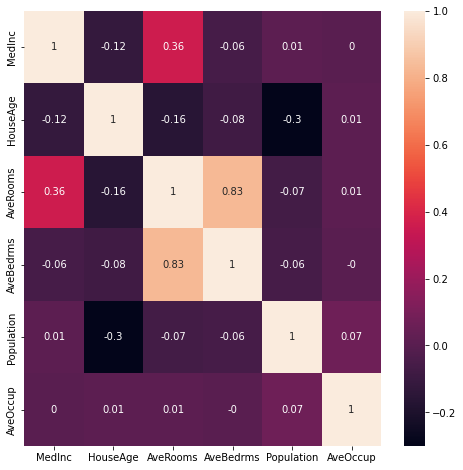

In [3]:
# We calculate the correlations using pandas corr()
# and we round the values to 2 decimals.
correlation_matrix = X_train.corr().round(2)

# Plot the correlation matrix usng seaborn.
# We use annot = True to print the correlation values
# inside the squares.

figure = plt.figure(figsize=(8, 8))
sns.heatmap(data=correlation_matrix, annot=True)

We see that `AveRooms` and `AveBdrms`, as expected, are highly correlated.

There is also some correlation between `AveRooms` and the `MedInc` of the `HouseAge` and `Population`.

## Train linear regression

In [4]:
# Our model needs an intercept so we add a column of 1s:

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [5]:
# Fit model

linreg = sm.OLS(y_train, X_train)
results = linreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     2942.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:49:32   Log-Likelihood:                -16796.
No. Observations:               14448   AIC:                         3.361e+04
Df Residuals:                   14441   BIC:                         3.366e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0659      0.028      2.340      0.0

## Coefficients direction (sign)

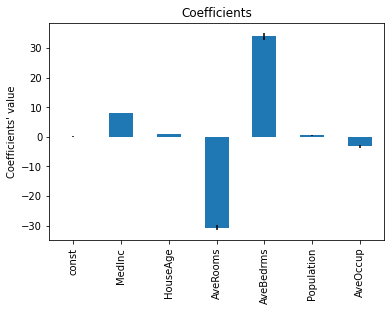

In [6]:
# Coefficients value

pd.Series(results.params, index=X_train.columns).plot.bar(
    yerr=pd.Series(results.bse))

plt.ylabel("Coefficients' value")
plt.title("Coefficients")
plt.show()

Even though the variables `AveRooms` and `AveBdrms` are highly correlated, they show a different direction in their contribution towards the target variable, and this is because of the correlation.

## Scatter plots

Let's explore the true relationship between `AveRooms` and `AveBdrms` and the target.

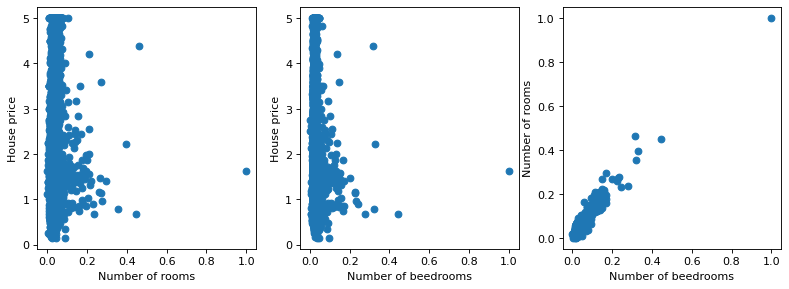

In [7]:
plt.figure(figsize=(12, 4), dpi=80)

plt.subplot(1, 3, 1)
plt.scatter(X_train['AveRooms'], y_train, marker="o")
plt.ylabel('House price')
plt.xlabel('Number of rooms')

plt.subplot(1, 3, 2)
plt.plot(X_train['AveBedrms'], y_train,marker="o", ls="")
plt.xlabel('Number of beedrooms')
plt.ylabel('House price')

plt.subplot(1, 3, 3)
plt.plot(X_train['AveBedrms'], X_train['AveRooms'], marker="o", ls="")
plt.xlabel('Number of beedrooms')
plt.ylabel('Number of rooms')


plt.show()

It is hard to see a clear association between `AveRooms` and `AveBdrms` and the target, but if anything else, by eye it looks very similar.

## Correlation with the target

Let's then calculate the correlation coefficient and its significance.

To learn more about Pearson's correlation coefficient:

- [Feature Selection for Machine Learning](https://www.trainindata.com/p/feature-selection-for-machine-learning) (course)
- [Feature Selection for Machine Learning in Python](https://leanpub.com/feature-selection-in-machine-learning/) (book)

In [8]:
# Pearson's correlation coefficient

r_regression(X_train[['AveRooms', 'AveBedrms']], y_train)

array([ 0.15925797, -0.0535532 ])

In [9]:
# Significance

f_regression(X_train[['AveRooms', 'AveBedrms']], y_train)[1:]

(array([1.07327230e-82, 1.18571192e-10]),)

There is a positive association between the number of rooms and the house price, that is also significant.

There is almost no association between the number of bedrooms and the house price.

## Remove correlated variable

Let's remove one of the correlated variables and re-train the model.

In [10]:
X_train = X_train.drop(columns=['AveBedrms'])

In [11]:
linreg = sm.OLS(y_train, X_train)
results = linreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     3168.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:49:33   Log-Likelihood:                -17216.
No. Observations:               14448   AIC:                         3.444e+04
Df Residuals:                   14442   BIC:                         3.449e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2191      0.028      7.692      0.0

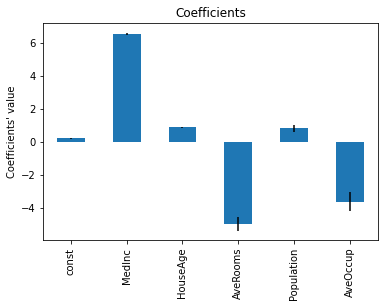

In [12]:
# Coefficients value

pd.Series(results.params, index=X_train.columns).plot.bar(
    yerr=pd.Series(results.bse))

plt.ylabel("Coefficients' value")
plt.title("Coefficients")
plt.show()

We still see that the number of bedrooms contributes negatively to the house price, even though it is positively correlated.

This is probably because it is correlated to `MedInc` and there is also some degree of correlation among other variables.

## Correlation between predictors and target

Let's examine each variable individually.

Text(0, 0.5, 'House price')

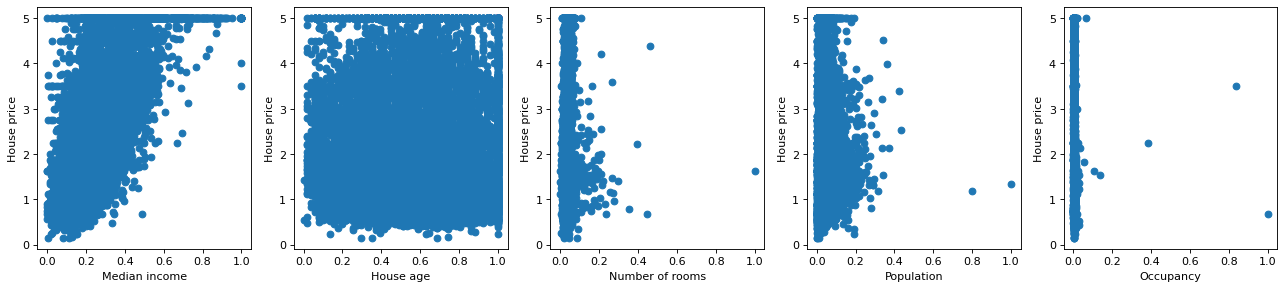

In [13]:
plt.figure(figsize=(20, 4), dpi=80)

plt.subplot(1, 5, 1)
plt.scatter(X_train['MedInc'], y_train, marker="o")
plt.xlabel('Median income')
plt.ylabel('House price')

plt.subplot(1, 5, 2)
plt.plot(X_train['HouseAge'], y_train,marker="o", ls="")
plt.xlabel('House age')
plt.ylabel('House price')

plt.subplot(1, 5, 3)
plt.scatter(X_train[ 'AveRooms'], y_train, marker="o")
plt.xlabel('Number of rooms')
plt.ylabel('House price')

plt.subplot(1, 5, 4)
plt.plot(X_train['Population'], y_train,marker="o", ls="")
plt.xlabel('Population')
plt.ylabel('House price')

plt.subplot(1, 5, 5)
plt.plot(X_train['AveOccup'], y_train,marker="o", ls="")
plt.xlabel('Occupancy')
plt.ylabel('House price')

In [14]:
coeffs = r_regression(X_train.drop(columns=["const"]), y_train)

coeffs

array([ 0.69327282,  0.10386295,  0.15925797, -0.02618285, -0.03076153])

In [15]:
# p values

pvalues = f_regression(X_train.drop(columns=["const"]), y_train)[1]

pvalues

array([0.00000000e+00, 6.01993542e-36, 1.07327230e-82, 1.64706337e-03,
       2.17231831e-04])

In [16]:
coeff_df = pd.DataFrame(
    {"corrcoef": coeffs, "pvalues": pvalues}, index=X_train.columns[1:])

coeff_df

,corrcoef,pvalues
MedInc,0.693273,0.000000e+00
HouseAge,0.103863,6.019935e-36
AveRooms,0.159258,1.073272e-82
Population,-0.026183,1.647063e-03
AveOccup,-0.030762,2.172318e-04


The contribution of `Population` and `AveOccup` seems to be negligible to the house price. If anything else, they have a negative association.

However, in the model they show a positive contribution towards the target variable.

In [17]:
# Let's remove those variables
X_train = X_train.drop(columns=['Population', "AveOccup"])

linreg = sm.OLS(y_train, X_train)
results = linreg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     5246.
Date:                Tue, 14 Nov 2023   Prob (F-statistic):               0.00
Time:                        10:49:35   Log-Likelihood:                -17241.
No. Observations:               14448   AIC:                         3.449e+04
Df Residuals:                   14444   BIC:                         3.452e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2653      0.024     10.980      0.0

We see that there is no decrease in R2 after removing those variables.

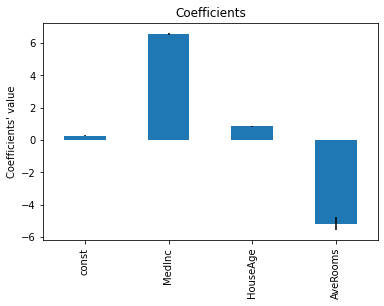

In [18]:
# Coefficients value

pd.Series(results.params, index=X_train.columns).plot.bar(
    yerr=pd.Series(results.bse))

plt.ylabel("Coefficients' value")
plt.title("Coefficients")
plt.show()

Text(0, 0.5, 'AveRooms')

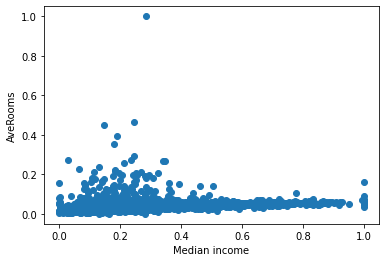

In [19]:
plt.scatter(X_train['MedInc'], X_train["AveRooms"], marker="o")
plt.xlabel('Median income')
plt.ylabel('AveRooms')

What seems to be happening is that for greater `MedInc` values, and hence higher house prices, there don't seem to be houses with more rooms. And the number of rooms seems to be taking the price down after accounting for the median income.

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='MedInc', ylabel='MedHouseVal'>

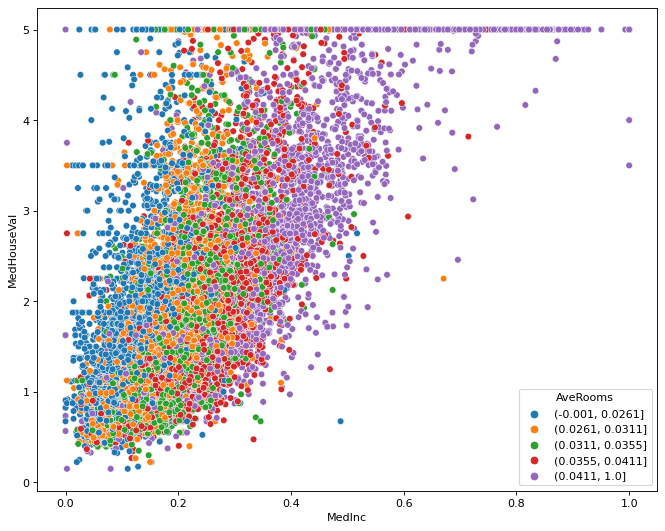

In [20]:
plt.figure(figsize=(10, 8), dpi=80)

sns.scatterplot(
    x=X_train['MedInc'],
    y=y_train, 
    hue=pd.qcut(X_train["AveRooms"], 5),
    )

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Figure size 1600x1600 with 0 Axes>

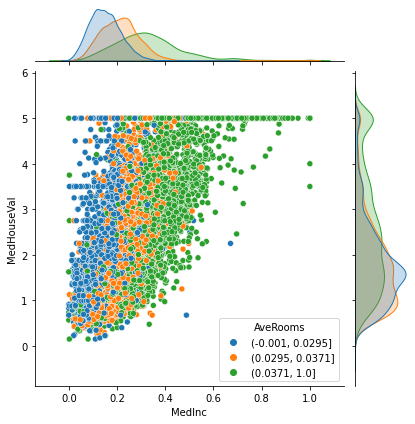

In [21]:
plt.figure(figsize=(20, 20), dpi=80)

sns.jointplot(
    x=X_train['MedInc'],
    y=y_train, 
    hue=pd.qcut(X_train["AveRooms"], 3),
)